In [1]:
from MacroRandomForest import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
start_date = "2000-01-01"

In [3]:
SP500_returns = pd.read_csv("erp_save.csv", index_col = "Date").loc[start_date:]
quantile_measures = pd.read_csv("df1_save.csv", index_col = "Date").loc[start_date:]
controls = pd.read_csv("df2_save.csv", index_col = "Date").loc[start_date:]

In [4]:
dep_variable = 'erp1w'

In [5]:
num_copies = 10

In [6]:
# Generating noisy carbon copies of the VRP: reason is that MRF doesn't accept very few variables 
for i in range(0, num_copies):
    controls[f"VRP_monthly_{i}"] = controls[f"VRP_monthly"].add(np.random.normal(0, 0.0000001))

In [7]:
MRF_data = pd.concat([SP500_returns[dep_variable], controls["VRP_monthly"]] + [controls[f"VRP_monthly_{i}"] for i in range(10)], axis = 1)
MRF_data = MRF_data.iloc[:-1] # Since the last day is nan for SP500_returns
MRF_data['trend'] = [i for i in range(MRF_data.shape[0])]

In [8]:
x_vars = ["VRP_monthly", "VRP_monthly_1", "VRP_monthly_2"]
x_pos = [MRF_data.columns.get_loc(var) for var in x_vars]

In [9]:
training_end = int(0.75*len(MRF_data))
testing_period = np.arange(training_end+1, len(MRF_data))

In [10]:
model = MacroRandomForest(data = MRF_data, 
                          x_pos = x_pos, 
                          oos_pos = testing_period, 
                          parallelise=True, 
                          n_cores = -1, 
                          B = 100, 
                          trend_push=1)

In [11]:
fitted = model._ensemble_loop()

Tree 2 out of 100
Tree 5 out of 100
Tree 1 out of 100
Tree 4 out of 100
Tree 6 out of 100
Tree 7 out of 100
Tree 3 out of 100
Tree 8 out of 100
Tree 9 out of 100
Tree 10 out of 100
Tree 11 out of 100
Tree 12 out of 100
Tree 13 out of 100
Tree 14 out of 100
Tree 15 out of 100
Tree 16 out of 100
Tree 17 out of 100
Tree 18 out of 100
Tree 19 out of 100
Tree 20 out of 100
Tree 21 out of 100
Tree 22 out of 100
Tree 23 out of 100
Tree 24 out of 100
Tree 25 out of 100
Tree 26 out of 100
Tree 27 out of 100
Tree 28 out of 100
Tree 29 out of 100
Tree 30 out of 100
Tree 31 out of 100
Tree 32 out of 100
Tree 33 out of 100
Tree 34 out of 100
Tree 35 out of 100
Tree 36 out of 100
Tree 37 out of 100
Tree 38 out of 100
Tree 39 out of 100
Tree 40 out of 100
Tree 41 out of 100
Tree 42 out of 100
Tree 43 out of 100
Tree 44 out of 100
Tree 45 out of 100
Tree 46 out of 100
Tree 47 out of 100
Tree 48 out of 100
Tree 49 out of 100
Tree 50 out of 100
Tree 51 out of 100
Tree 52 out of 100
Tree 53 out of 100
Tr

In [12]:
index_for_plotting = pd.DatetimeIndex(controls.index[:-1])

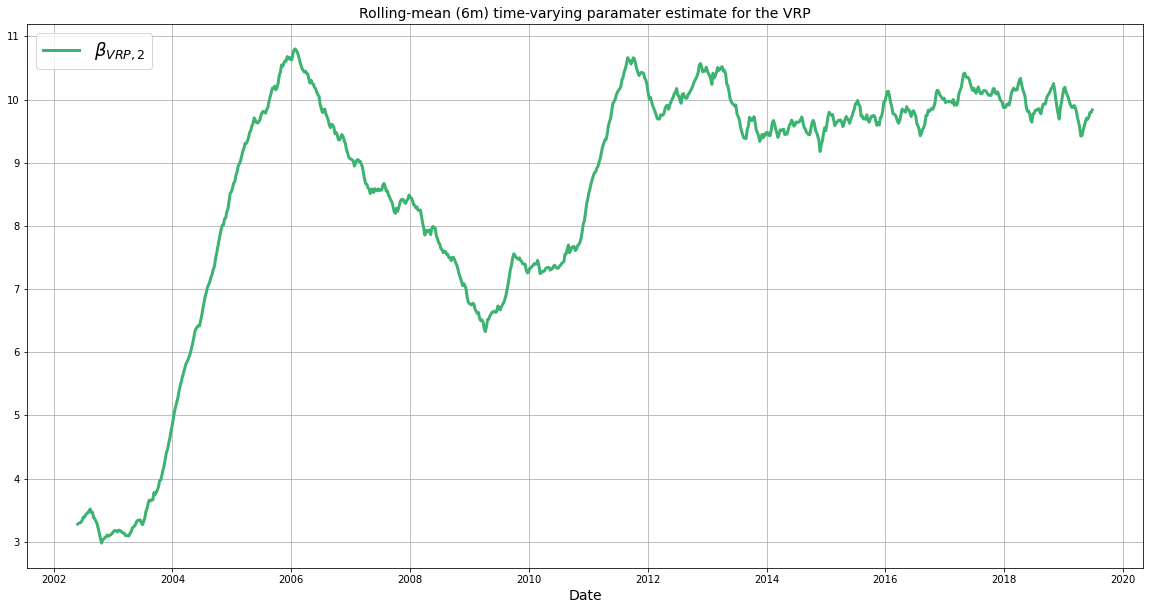

In [52]:
fig, ax = plt.subplots()
betas = pd.DataFrame(fitted['betas'])
betas.index = index_for_plotting
VRP_beta1 = betas[1]
ax.plot(VRP_beta1.rolling(126).mean(), label= r"$\beta_{VRP, 2}$", color = 'mediumseagreen', linewidth = 3)
fig.set_size_inches(20, 10)
ax.legend(fontsize = 18, loc = 2)
ax.set_title("Rolling-mean (6m) time-varying paramater estimate for the VRP", fontsize = 14)
ax.set_xlabel("Date", fontsize = 14)
ax.grid('on')

In [14]:
actual_oos = SP500_returns[dep_variable].iloc[testing_period]
actual_oos.index = pd.DatetimeIndex(actual_oos.index)
predictions = fitted['pred'].set_index(actual_oos.index)

In [15]:
together = pd.concat([actual_oos, predictions], axis = 1)

In [16]:
together['In-Sample Mean'] = SP500_returns[dep_variable].iloc[:training_end].mean()

In [17]:
MAE_MRF = abs(together[dep_variable].subtract(together['Ensembled_Prediction'])).mean()

In [18]:
MAE_IS_Mean = abs(together[dep_variable].subtract(together['In-Sample Mean'])).mean()

In [19]:
MAE_MRF, MAE_IS_Mean

(5.1485324531189836, 4.936835226796453)

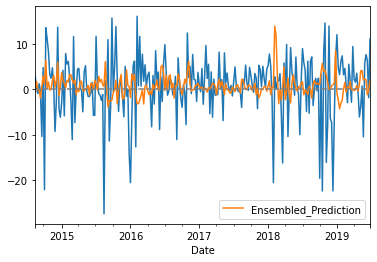

In [24]:
fig, ax = plt.subplots()
actual_oos.plot(ax =ax)
predictions.plot(ax = ax)
ax.axhline(together["In-Sample Mean"][0], linestyle = '--', color = 'grey')